# Tutorial: supervision with ordinal labels

In [ ]:
#pip install pacmap KDEpy

In [86]:
import numpy as np
import scanpy as sc
import pacmap
import stream2 as st2
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

# Load data
We directly load preprocessed data from Schiebinger 2019 subsampled to ~10% of points with geosketch

Uncomment the cell below if you wish to replicate preprocessing yourself

In [87]:
adata = sc.read('../data/reprogramming/wot.h5ad')

In [ ]:
## download data from https://broadinstitute.github.io/wot/tutorial/
#import wot
#import pandas as pd

#PATH = '../../git/wot/notebooks/data/'
#
##---Path to input files
#FLE_COORDS_PATH ='data/fle_coords.txt'
#FULL_DS_PATH = 'data/ExprMatrix.h5ad'
#VAR_DS_PATH = 'data/ExprMatrix.var.genes.h5ad'
#CELL_DAYS_PATH = 'data/cell_days.txt'
#GENE_SETS_PATH = 'data/gene_sets.gmx'
#GENE_SET_SCORES_PATH = 'data/gene_set_scores.csv'
#CELL_SETS_PATH = 'data/cell_sets.gmt'
#MAJOR_CELL_SETS_PATH = 'data/major_cell_sets.gmt'
#SERUM_CELL_IDS_PATH = 'data/serum_cell_ids.txt'
#CELL_GROWTH_PATH = 'data/growth_gs_init.txt'
#
#coord_df = pd.read_csv(PATH+FLE_COORDS_PATH, index_col='id', sep='\t')
#days_df = pd.read_csv(PATH+CELL_DAYS_PATH, index_col='id', sep='\t')
#gene_set_df = pd.read_csv(PATH+GENE_SET_SCORES_PATH, index_col='id').rename(columns={'Trophoblast':'Trophoblast.identity'})
#cell_sets = wot.io.read_sets(PATH+CELL_SETS_PATH)
#serum_id = pd.read_csv(PATH+SERUM_CELL_IDS_PATH,header=None)
#adata = sc.read_h5ad(PATH+VAR_DS_PATH)
#
## subset labeled days
#adata.obs['label']=days_df
#adata=adata[~adata.obs['label'].isna()].copy()
#sc.pp.pca(adata)
#
## add annotations
#df=cell_sets.to_df()
#df['cell_sets'] = ''
#for c in df.columns[:-1]: 
#    df.loc[df[c]>0,'cell_sets']=c
#adata.obs=adata.obs.join(df)
#adata.obs.loc[adata.obs['cell_sets'].isna(),'cell_sets']='nan'
#adata.obs['cell_sets']=adata.obs['cell_sets'].astype(str)
#
#adata.obs['cell_sets_simple']=adata.obs['cell_sets'].copy()
#adata.obs['cell_sets_simple'][adata.obs['cell_sets'].isin(['Trophoblast','SpongioTropho','ProgenitorTropho','SpiralArteryTrophoGiant'])] = 'Trophoblast'
#adata.obs['cell_sets_simple'][adata.obs['cell_sets'].isin(['Neural','RadialGlia','Neuron','Astrocyte'])] = 'Neural'  
#adata.uns['cell_sets_simple_color'] = {
# 'Epithelial': '#EC8E26',
# 'IPS': '#c0c1c0',
# 'MET': '#9e50c7',
# 'Neural': '#47e026',
# 'OPC': '#7f7f7f',
# 'Stromal': '#3f4af4',
# 'Trophoblast': '#b5361a',
# 'nan': '#434342'}
#
#adata.obs['serum']='0'
#adata.obs['serum'][adata.obs.index.isin(serum_id[0].values)]='1'
#
#from geosketch import gs
#sketch_index = gs(adata.obsm['X_pca'], N=25000, replace=False,seed=0)
#s_adata = adata[sketch_index]
#s_adata.write('../data/wot.h5ad')

### compute cytotrace scores using pyrovelocity implementation
#import sys
#sys.path.append('../../pyrovelocity/pyrovelocity/')
#import cytotrace
#import sklearn
#
#PATH = '../../wot/notebooks/data/'
#FULL_DS_PATH = 'data/ExprMatrix.h5ad'
#adata_full = sc.read_h5ad(PATH+FULL_DS_PATH)
#s_adata = sc.read('../data/reprogramming/wot.h5ad')
#s_adata_full = adata_full[s_adata.obs_names].copy()
#ss_adata_full = sc.pp.subsample(s_adata_full,n_obs=5000,copy=True)
#cyto = cytotrace.cytotrace(ss_adata_full,layer=None)
#
#knnreg = sklearn.neighbors.KNeighborsRegressor(weights='distance').fit(ss_adata_full.X,cyto['CytoTRACE'])
#s_adata.obs['CytoTRACE'] = knnreg.predict(s_adata_full.X)

# Supervised dimension reduction

In this dataset cells are already quite well ordered by time. Still there are discrepancies where earlier cells are sampled near the tip of the distribution, after cells from later days and vice versa

If needed we can smooth outlier ordinal labels by voting. Here it doesn't matter much

In [94]:
k = 30

knn_label_vote = adata.obs['label'].copy()
dis, idx = NearestNeighbors(n_neighbors=k,n_jobs=30).fit(adata.obsm['X_pca']).kneighbors()

for i, x in enumerate(np.array(adata.obs['label'])[idx]):
    unique, count = np.unique(x, return_counts=1)
    argmax = np.argmax(count)
    if count[argmax] > k/2: 
        knn_label_vote[i] = unique[argmax]
        
adata.obs['knn_label_vote'] = knn_label_vote

We perform unsupervised dimensionality reduction as baseline

/home/jo/anaconda3/envs/stream2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


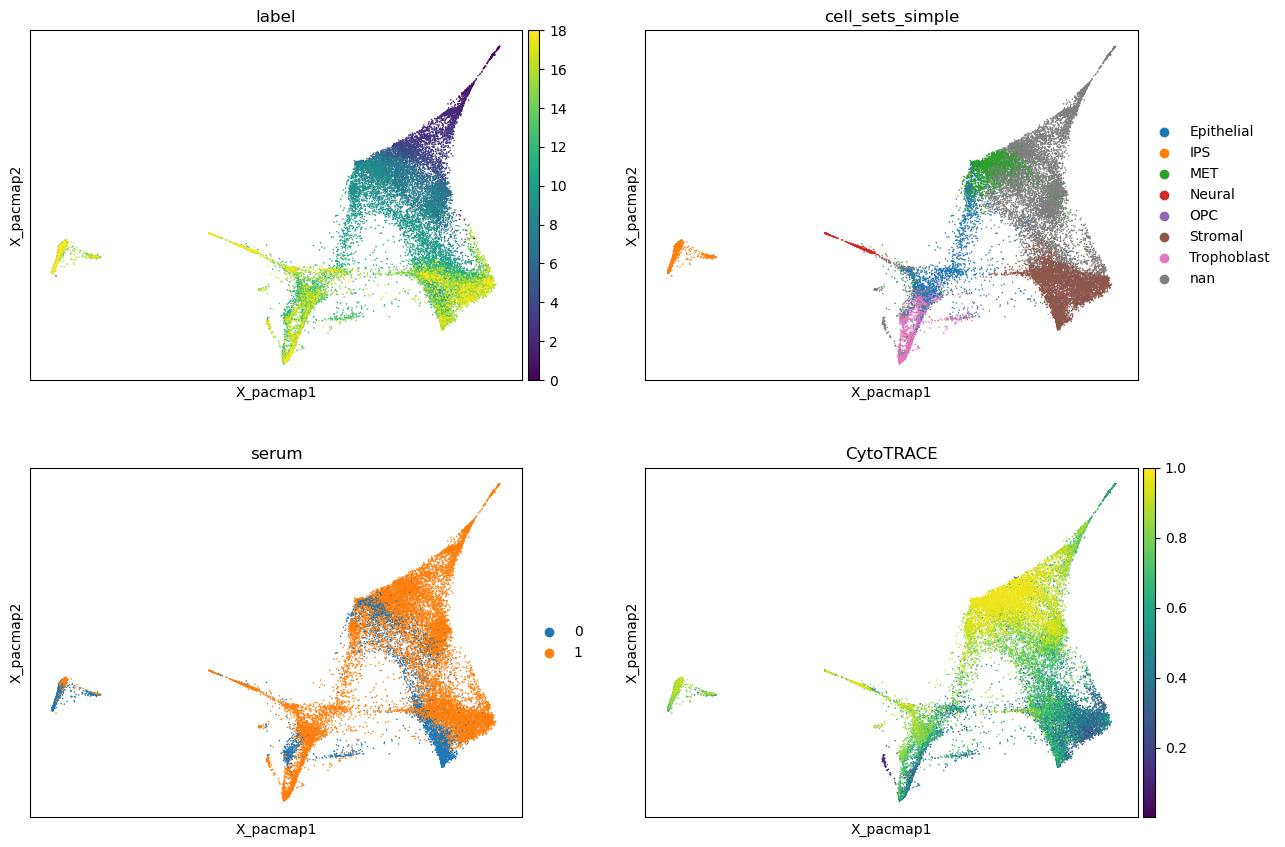

In [6]:
if "X_pacmap" not in adata.obsm:
    adata.obsm['X_pacmap'] = pacmap.PaCMAP(n_neighbors=k, distance='angular',random_state=0, FP_ratio=.4).fit_transform(adata.obsm['X_pca'])
sc.pl.embedding(adata,basis='X_pacmap',color=['label','cell_sets_simple','serum','CytoTRACE'],ncols=2)

There is usually a decision to be made which notion of time we care more about respecting: pseudotime (e.g., following data density or the number of expressed genes) vs wall time. Heuristic tools such as CytoTRACE (https://cytotrace.stanford.edu/) and psupertime (https://github.com/wmacnair/psupertime) can help to define pseudotime and find a consensus with wall time labels. 

In case we decide to more closely follow wall time, a simple solution is to perform supervised dimensionality reduction by using ordinal labels and choosing a supervision strength.

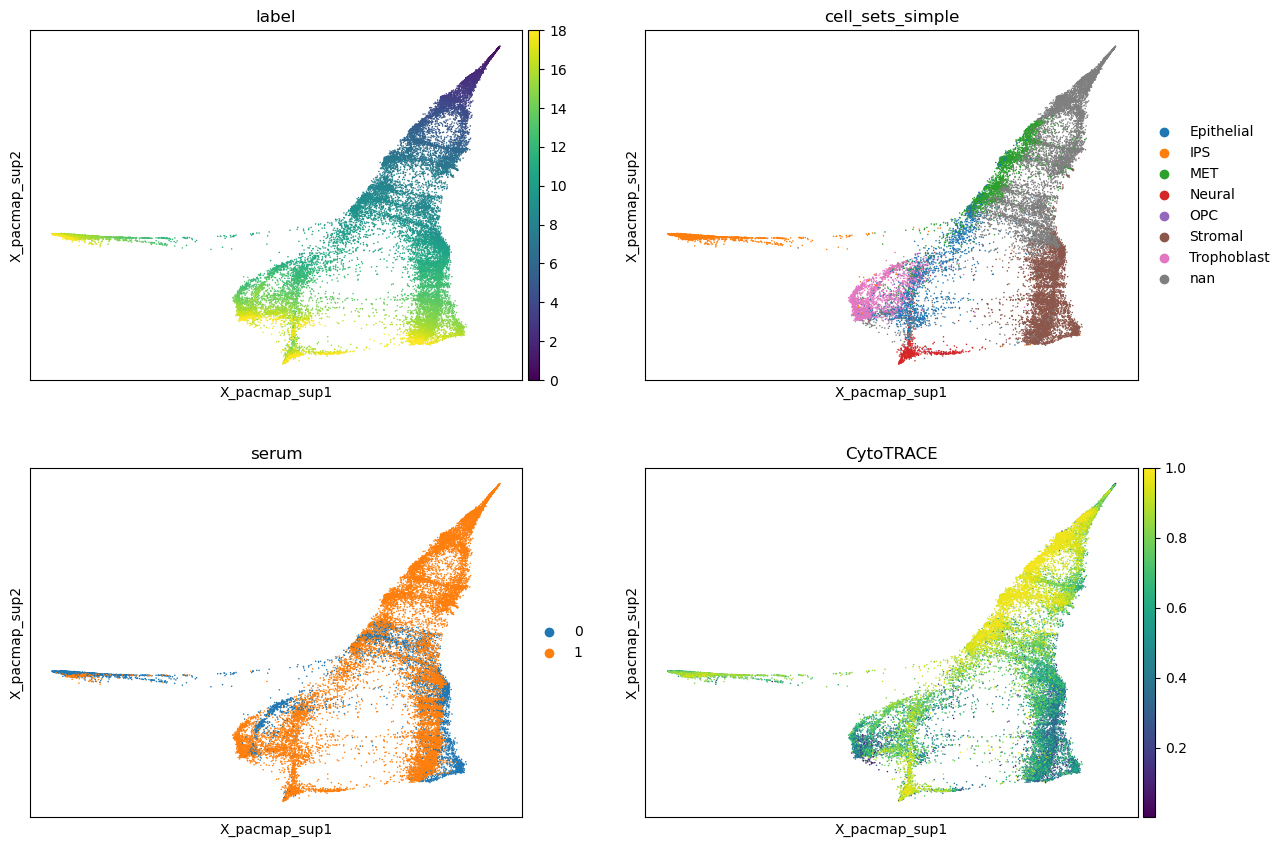

In [7]:
if "X_pacmap_sup" not in adata.obsm:
    knn_dists,knn_idx = st2.tl.ordinal_knn(adata,obsm='X_pca',ordinal_label='label', method='force',
                                              n_neighbors = k, n_natural = 2, metric = 'cosine')


    scaled_dist = np.ones_like(knn_idx,dtype='float32')
    pair_neighbors = pacmap.sample_neighbors_pair(adata.obsm['X_pca'], scaled_dist, knn_idx, k)
    adata.obsm['X_pacmap_sup'] = pacmap.PaCMAP(n_neighbors=k,random_state=0,FP_ratio=.4,
                                               pair_neighbors=pair_neighbors).fit_transform(adata.obsm['X_pca'])
sc.pl.embedding(adata,basis='X_pacmap_sup',color=['label','cell_sets_simple','serum','CytoTRACE'],ncols=2)

# Trajectory inference
Let us seed the graph with a minimum spanning tree. 
We can see that 10 clusters are not enough

Seeding initial graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...


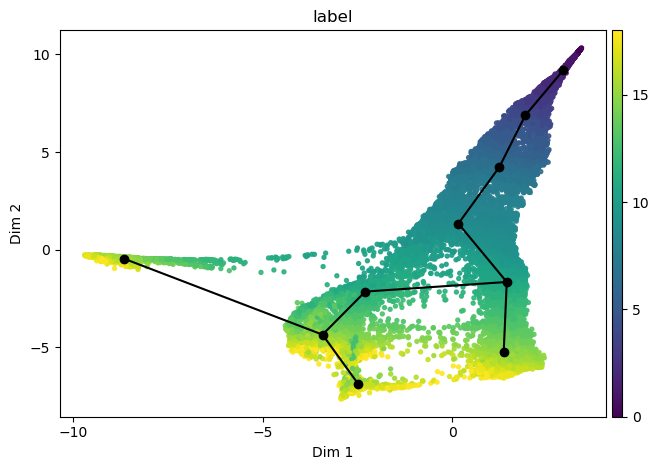

In [89]:
adata.obsm['X_dr']=adata.obsm['X_pacmap_sup']
st2.tl.seed_graph(adata,n_clusters=10,use_weights=False)
st2.pl.graph(adata,key='seed_epg',color=['label'],show_node=1)

A simple solution is to increase the number of clusters

Seeding initial graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...


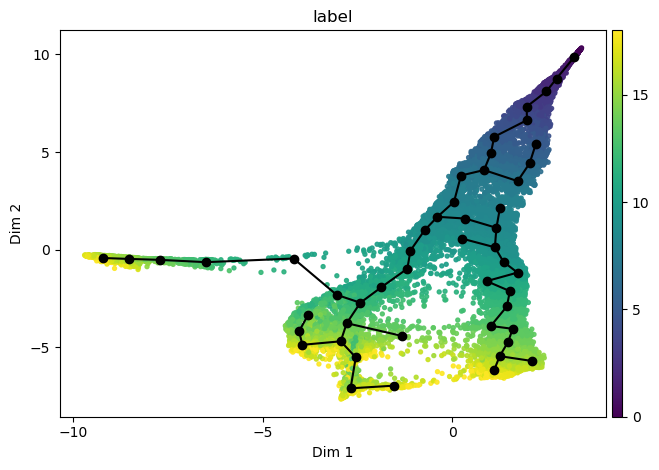

In [90]:
st2.tl.seed_graph(adata,n_clusters=50,use_weights=False)
st2.pl.graph(adata,key='seed_epg',color=['label'],show_node=1)

The seed graph is still not ideal, e.g. for IPS cells because the start of the branch
is very sparse.

This can be improved by computing density and assigning higher weights to points in sparse regions of data

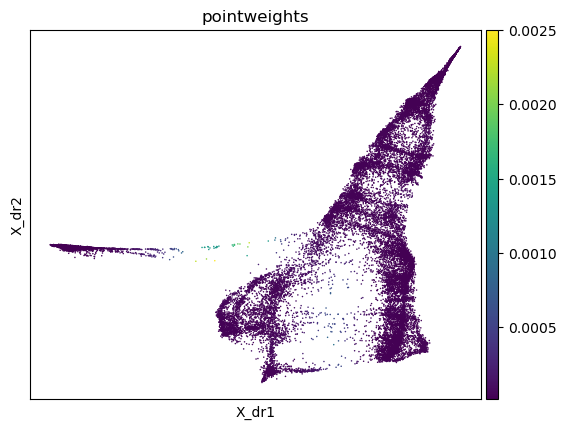

Seeding initial graph...
Clustering...
K-Means clustering ...
Calculating minimum spanning tree...


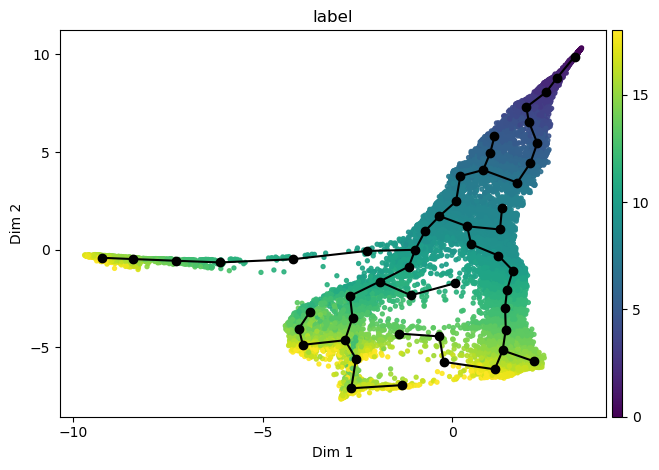

In [91]:
st2.tl.get_weights(adata,bandwidth=.5,method='fft')
sc.pl.embedding(adata,basis='X_dr',color='pointweights')

st2.tl.seed_graph(adata,n_clusters=50,use_weights=True)
st2.pl.graph(adata,key='seed_epg',color=['label'],show_node=1)

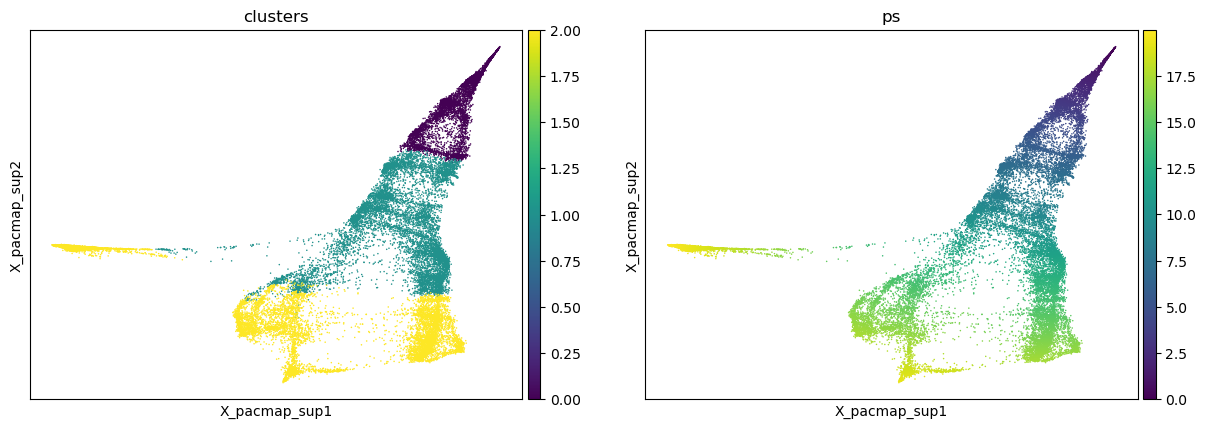

In [92]:
#define a root point
root_idx = 0
time = adata.obs['label']
bins = np.histogram(time, bins=3)[1]
adata.obs['clusters'] = np.digitize(time, bins[1:], right=True)

st2.tl.smooth_ordinal_labels(adata, root_idx, ordinal_label='clusters', obsm="X_pacmap_sup")
sc.pl.embedding(adata,'X_pacmap_sup',color=['clusters','ps'])

We then need to define 3 extra variables: root cell, ordinal labels to follow and supervision strength
- ordinal_supervision_strength = 1 means equal importance to respecting ordinal labels vs natural data order,
- ordinal_supervision_strength = 10 means following ordinal labels is 10 times more important 

In [ ]:
adata2=adata.copy()
st2.tl.learn_graph(
    adata2,
    n_nodes=100,epg_alpha=0.02,epg_mu=0.1,epg_lambda=0.01,
    GPU=False,store_evolution=True,use_weights=True,use_seed=True,
    max_candidates={'AddNode2Node': 15, 'BisectEdge': 10, 'ShrinkEdge':10},verbose=1,
                   
    # supervision parameters
    ordinal_label = 'knn_label_vote',                            #define the ordinal vector to follow
    ordinal_root_point = root_idx,                               #define a root point (e.g., cell with lowest ordinal value)
    ordinal_supervision_strength = 1,                            #define strength of supervision in [0, +inf).
)

st2.pl.graph(adata2,key='epg',color=['label','cell_sets_simple'],alpha=.2,size=2)
#st2.pl.graph(adata2,key='epg',color=['label','cell_sets_simple'],alpha=.2,size=2,
#            fig_path=f'figures/reprogramming/shareseq_stream_umap.png',save_fig=True)

NameError: name 'root_idx' is not defined

For best results we infer the graph without the max candidates heuristic and fine tune nodes and supervision strength parameters

Constructing tree 1 of 1 / Subset 1 of 1
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  110  nodes on  25000  points and  2  dimensions

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

6||52	0.5412	52	51	38	6	0	0	0.2401	0.199	0.9929	0.9941	0.2913	0.0098	0.5105	26.5441	0
6||53	0.519	53	52	39	6	0	0	0.223	0.1834	0.9934	0.9946	0.2858	0.0102	0.538	28.5148	0
5||54	0.497	54	53	42	5	0	0	0.2158	0.1771	0.9936	0.9948	0.271	0.0102	0.5486	29.6251	0
5||55	0.4798	55	54	43	5	0	0	0.2043	0.1674	0.994	0.9951	0.2663	0.0091	0.5032	27.6746	0
5||56	0.4665	56	55	44	5	0	0	0.1998	0.1666	0.9941	0.9951	0.2571	0.0096	0.5382	30.1379	0
4||57	0.4697	57	56	47	4	0	0	0.215	0.1813	0.9937	0.9947	0.2481	0.0066	0.3762	21.4451	0
4||58	0.4649	58	57	48	4	0	0	0.2112	0.1781	0.9938	0.9948	0.247	0.0066	0.3853	22.3459	0
4||59	0.4512	59	58	49	4	0	0	0.2119	0.1816	0.9938	0.9947	0.2328	0.0065	0.3856	22.7532	0
3||60	0.4411	60	59	52	3	0	0	0.2133	0.184

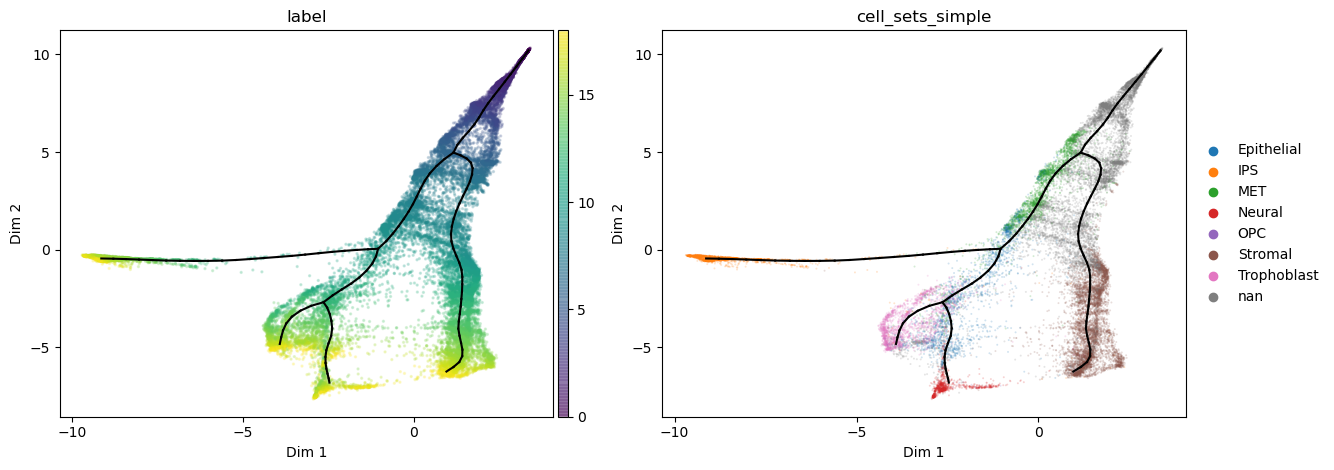

In [95]:
adata2=adata.copy()
st2.tl.learn_graph(
    adata2,
    n_nodes=110,epg_alpha=0.02,epg_mu=0.1,epg_lambda=0.01,
    GPU=False,store_evolution=True,use_weights=True,use_seed=True,verbose=1,
                   
    # supervision parameters
    ordinal_label = 'knn_label_vote',                            #define the ordinal vector to follow
    ordinal_root_point = root_idx,                               #define a root point (e.g., cell with lowest ordinal value)
    ordinal_supervision_strength = 2.5,                            #define strength of supervision in [0, +inf).
)

st2.pl.graph(adata2,key='epg',color=['label','cell_sets_simple'],alpha=.2,size=2)
#st2.pl.graph(adata2,key='epg',color=['label','cell_sets_simple'],alpha=.2,size=2,
#            fig_path=f'figures/reprogramming/shareseq_stream_umap.png',save_fig=True)

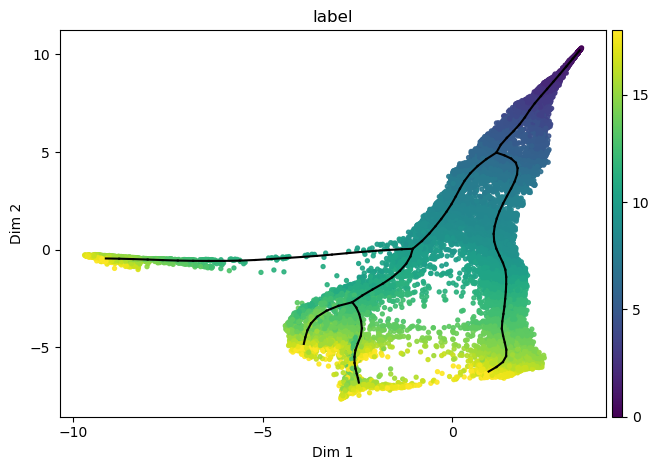

In [13]:
st2.tl.use_graph_with_n_nodes(adata2,n_nodes=110)
st2.pl.graph(adata2,key='epg',color=['label'])

# Pseudotime and trajectory plots

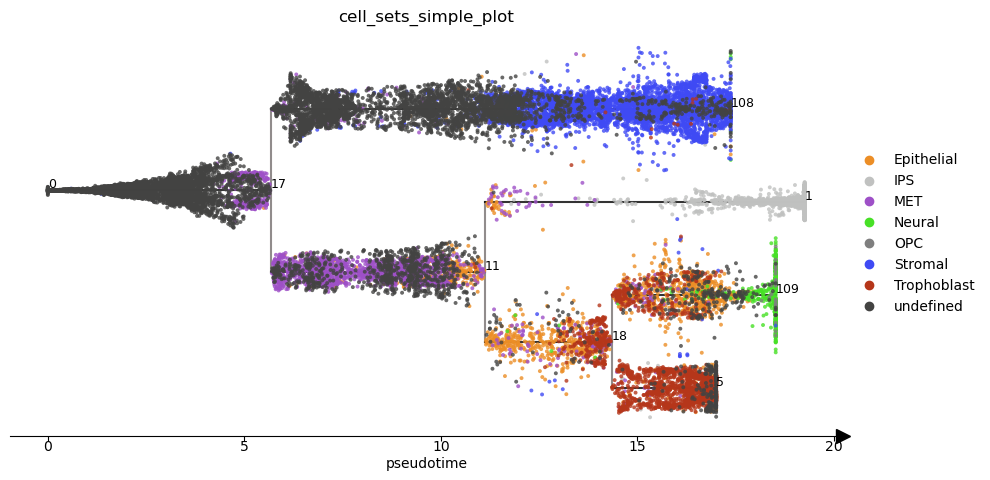

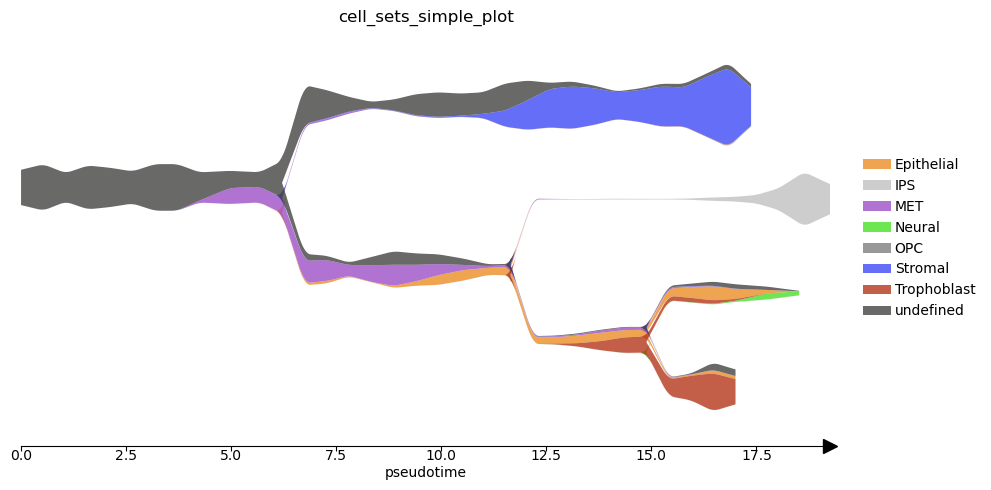

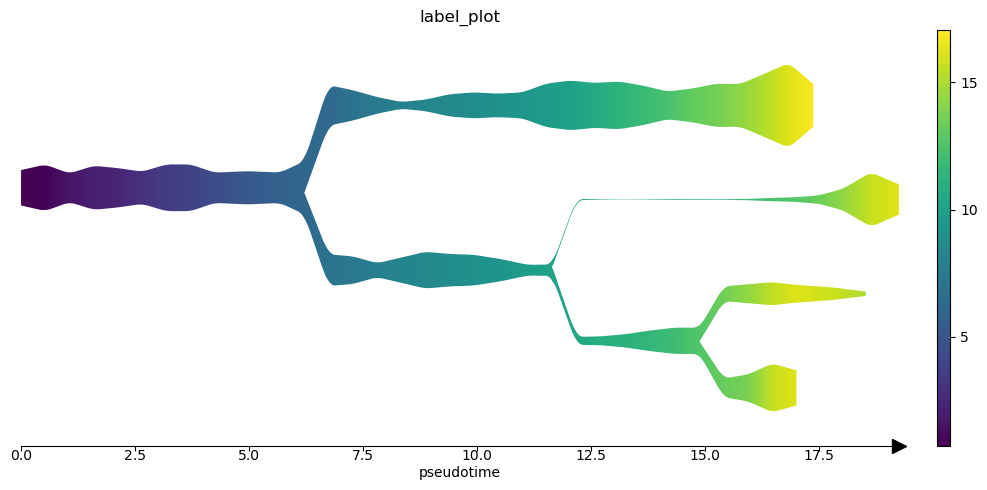

In [100]:
st2.tl.infer_pseudotime(adata2,0)

# match colors with original manuscript
adata2.obs['cell_sets_simple_plot'] = adata2.obs['cell_sets_simple'].replace('nan','undefined')
adata2.uns['cell_sets_simple_plot_color'] = {
 'Epithelial': '#EC8E26',
 'IPS': '#c0c1c0',
 'MET': '#9e50c7',
 'Neural': '#47e026',
 'OPC': '#7f7f7f',
 'Stromal': '#3f4af4',
 'Trophoblast': '#b5361a',
 'undefined': '#434342'}

adata2.uns['cell_sets_simple_plot_colors'] = adata2.uns['cell_sets_simple_plot_color'].values()
dict_palette = {'cell_sets_simple_plot':adata2.uns['cell_sets_simple_plot_color']}

#jitter to prevent bug for equal pseudotime values
adata2.obs['label_plot']=adata2.obs['label']+1e-20*np.random.random(len(adata2))

st2.pl.stream_sc(adata2,source=0,preference=[108,1,109,5],dist_scale=.5,color=['cell_sets_simple_plot'],fig_size=(10,5),dict_palette=dict_palette)

#show
st2.pl.stream(adata2,source=0,preference=[108,1,109,5],factor_min_win=2.5,color=['cell_sets_simple_plot'],fig_size=(10,5),
             fig_path=f'figures/reprogramming/shareseq_stream_cell_sets_simple',dict_palette=dict_palette)
st2.pl.stream(adata2,source=0,preference=[108,1,109,5],factor_min_win=2.5,color=['label_plot'],fig_size=(10,5),
             fig_path=f'figures/reprogramming/shareseq_stream_timepoints',)

#save png
st2.pl.stream(adata2,source=0,preference=[108,1,109,5],factor_min_win=2.5,color=['cell_sets_simple_plot'],fig_size=(10,5),
             fig_path=f'figures/reprogramming/shareseq_stream_cell_sets_simple',save_fig=True,fig_format='png',dict_palette=dict_palette)
st2.pl.stream(adata2,source=0,preference=[108,1,109,5],factor_min_win=2.5,color=['label_plot'],fig_size=(10,5),
             fig_path=f'figures/reprogramming/shareseq_stream_timepoints',save_fig=True,fig_format='png')

#save pdf
st2.pl.stream(adata2,source=0,preference=[108,1,109,5],factor_min_win=2.5,color=['cell_sets_simple_plot'],fig_size=(10,5),
             fig_path=f'figures/reprogramming/shareseq_stream_cell_sets_simple',save_fig=True,fig_format='pdf',dict_palette=dict_palette)
st2.pl.stream(adata2,source=0,preference=[108,1,109,5],factor_min_win=2.5,color=['label_plot'],fig_size=(10,5),
             fig_path=f'figures/reprogramming/shareseq_stream_timepoints',save_fig=True,fig_format='pdf')

/home/jo/anaconda3/envs/stream2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/tmp/ipykernel_79/4153202302.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in ax.get_legend().legendHandles:


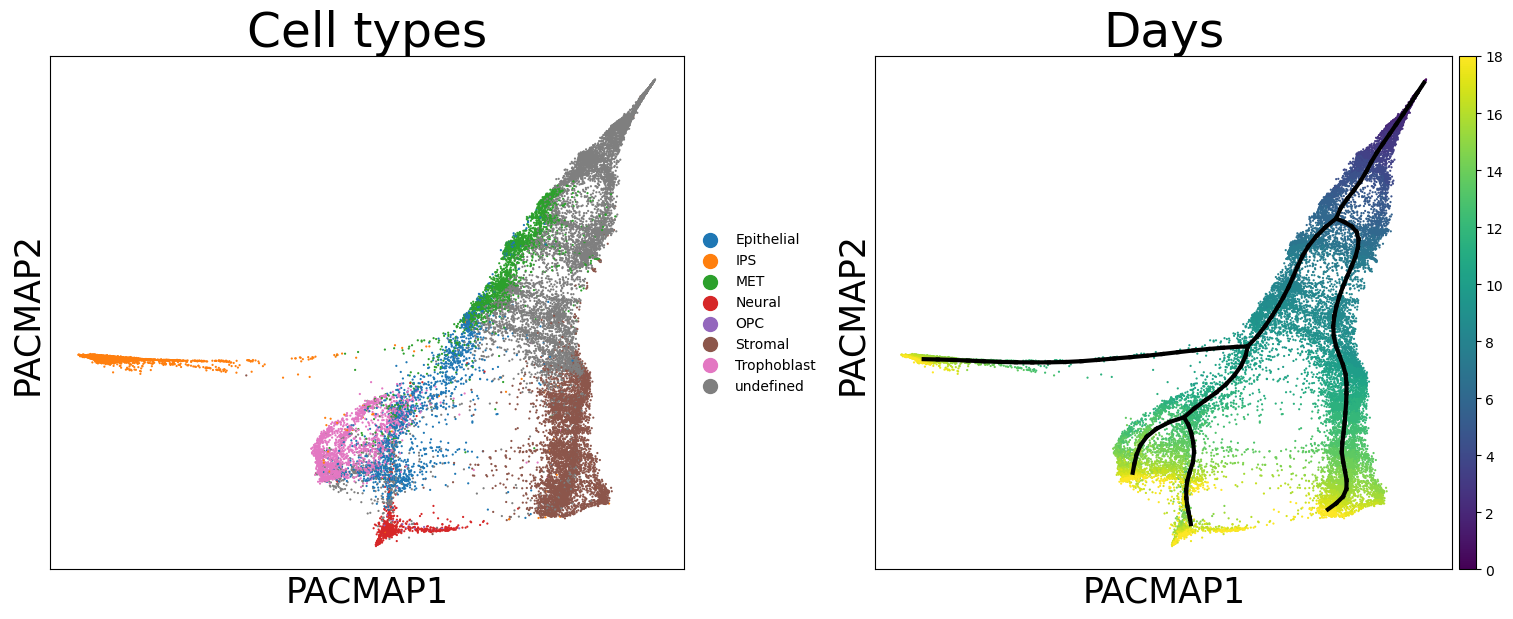

In [25]:
f,axs=plt.subplots(1,2,figsize=(15,6))

annot=['cell_sets_simple_plot','label',]
annot_name=['Cell types','Days',]

nodep=adata2.uns['epg']['node_pos']
edges=adata2.uns['epg']['edge']

adata2.obsm['X_umap']=adata2.obsm['X_pacmap_sup']
for i,key in enumerate(annot):
    ax=axs[i]
    if i==1:
        ax=sc.pl.umap(adata2,color=key,cmap='viridis',ax=ax,show=False,s=10)
        for e in edges:
            ax.plot(*nodep[e].T,linewidth=3,color='k')
    else:
        ax=sc.pl.umap(adata2,color=key,ax=ax,show=False,s=10)
        
    ax.set_title(annot_name[i],fontsize=35)
    ax.set_xlabel('PACMAP1',fontsize=25)
    ax.set_ylabel('PACMAP2',fontsize=25)
    if i!=1:
        #ax.legend(prop=dict(size=18),bbox_to_anchor=[1.2, 0.5], loc='center')
        for lh in ax.get_legend().legendHandles: 
            lh._sizes = [100] 

plt.tight_layout(pad=0,w_pad=1)
plt.savefig(f'figures/reprogramming/pacmap.png',dpi=300,bbox_inches='tight')
plt.savefig(f'figures/reprogramming/pacmap.pdf',dpi=300,bbox_inches='tight')
plt.show()

# Save results

In [ ]:
#these keys might fail to write
#del adata2.uns['epg']['conn']
#del adata2.uns['seed_epg']['conn']
#del adata2.uns['epg']['graph_evolution']
#del adata2.uns['stream_tree']
#adata2.write('../data/test.h5ad')